<a href="https://colab.research.google.com/github/princexoleo/face-mask-detector/blob/master/face_mask_detect_model_fastai.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Preparing dataset from Drive folder

In [0]:
from fastai import *
from fastai.vision import *

In [0]:
import shutil

In [0]:
shutil.rmtree("/content/data")

In [0]:
from zipfile import ZipFile

In [0]:
file_name = "/content/data.zip"
with ZipFile(file_name,'r')as zip:
  zip.extractall("/content/")
  print("Done")

Done


##Try to Load Into fastai


In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [0]:
# load data
data_dir = "/content/data"
path = Path(data_dir)
path.ls()

[PosixPath('/content/data/valid'), PosixPath('/content/data/train')]

ERROR! Session/line number was not unique in database. History logging moved to new session 59
torch.Size([3, 98, 98])


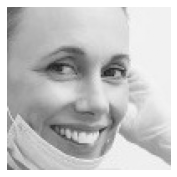

In [0]:
img = open_image("/content/data/train/mask/mask3000.jpg")
print(img.data.shape)
img.show()

In [0]:
tfms = get_transforms()
bs = 64
sz = 224

In [0]:
data = ImageDataBunch.from_folder(path,
                                  valid='valid',
                                  valid_pct=0.2,
                                  bs=bs,
                                  ds_tfms=tfms,
                                  size=sz).normalize(imagenet_stats)

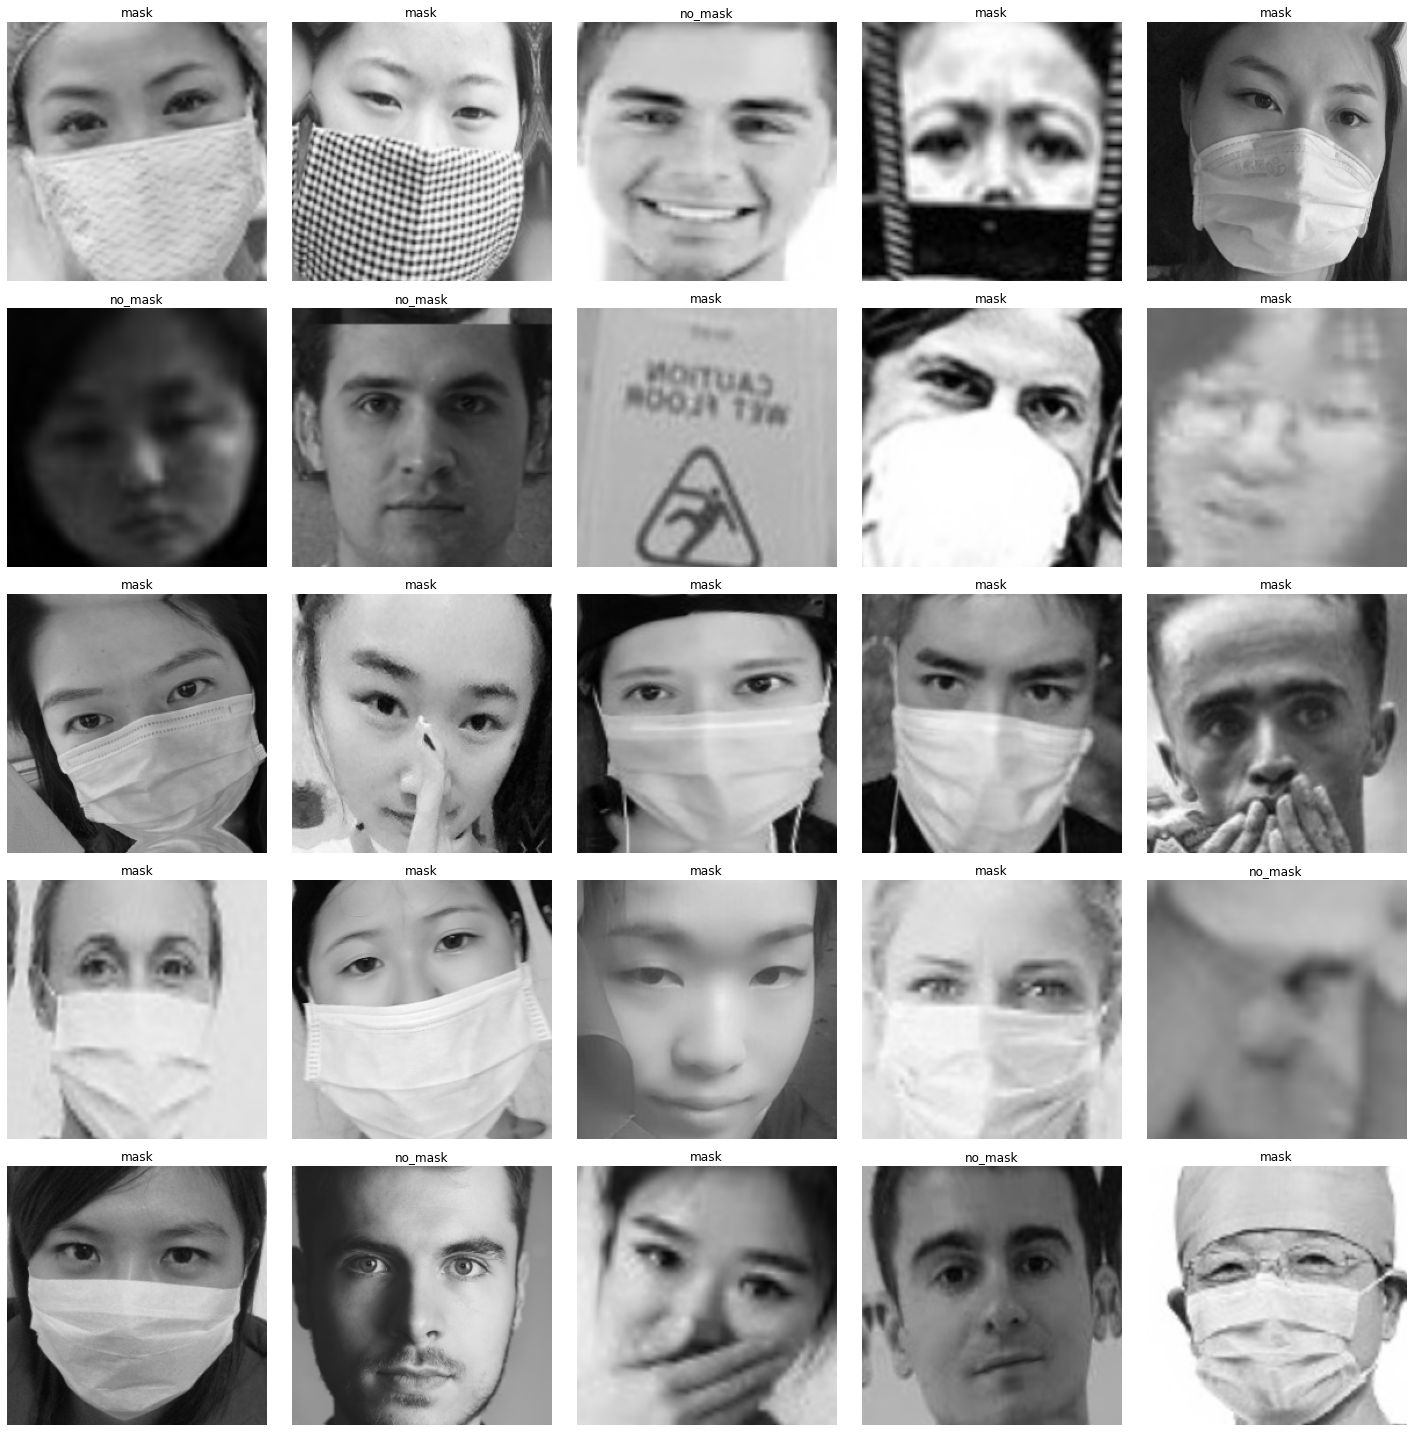

In [0]:
# show some data
data.show_batch()

In [0]:
# load model with pretrained data
learner = cnn_learner(data, models.resnet34, pretrained=True, metrics=[accuracy])

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/checkpoints/resnet34-333f7ec4.pth


In [0]:
learner.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


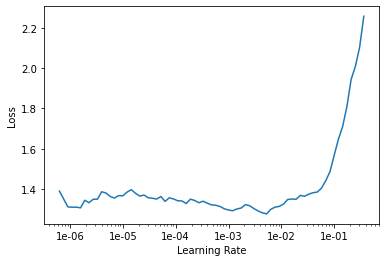

In [0]:
learner.recorder.plot()

In [0]:
learner.fit_one_cycle(3)

epoch,train_loss,valid_loss,accuracy,time
0,0.926559,0.598996,0.748166,00:16
1,0.737842,0.475548,0.789731,00:16
2,0.580035,0.379390,0.841076,00:16


In [0]:
print(data.classes)
print(data.train_ds)
print(data.valid_ds)

['mask', 'no_mask']
LabelList (1637 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
mask,mask,mask,mask,mask
Path: /content/data
LabelList (409 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
no_mask,no_mask,mask,mask,no_mask
Path: /content/data


In [0]:
learner.save('stage-1')

##Testing purpose

In [0]:
img = open_image("/content/data/valid/mask/mask4069.jpg")
no_mask_image = open_image("/content/data/valid/no_mask/no_mask486.jpg")

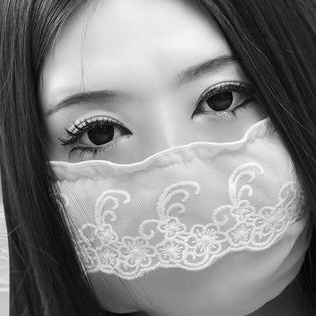

In [0]:
img

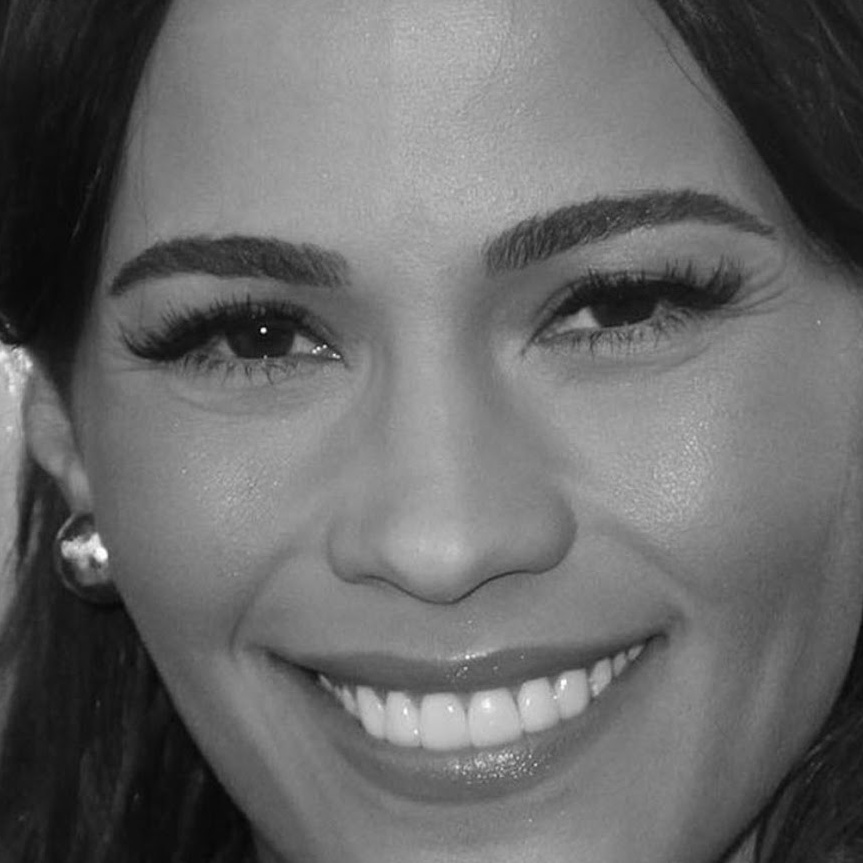

In [0]:
no_mask_image

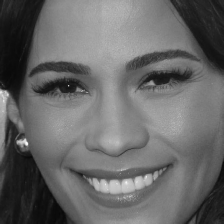

In [0]:
no_mask_image.resize(224)

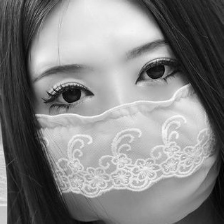

In [0]:
img.resize(224)

In [0]:
learner.predict(img)

(Category mask, tensor(0), tensor([0.8904, 0.1096]))

In [0]:
learner.load('stage-1')
learner.unfreeze()

In [0]:
learner.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 3.31E-06
Min loss divided by 10: 9.12E-08


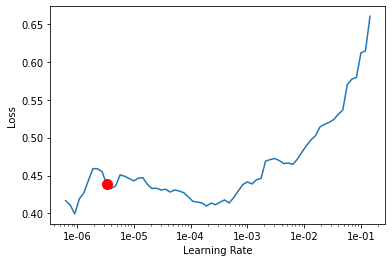

In [0]:
learner.recorder.plot(suggestion=True)

In [0]:
learner.fit_one_cycle(10, max_lr=slice(3e-6,3e-5))

epoch,train_loss,valid_loss,accuracy,time
0,0.427418,0.378606,0.853301,00:17
1,0.428258,0.367994,0.848411,00:17
2,0.402949,0.357288,0.853301,00:17
3,0.385623,0.345692,0.872861,00:17
4,0.359502,0.330913,0.882641,00:17
5,0.341222,0.332964,0.870416,00:17
6,0.314402,0.317386,0.887531,00:17
7,0.310522,0.313231,0.882641,00:17
8,0.308960,0.306775,0.889976,00:17
9,0.293526,0.309759,0.885086,00:17


In [0]:
learner.save('stage-2')

In [0]:
learner.load('stage-2')
learner.unfreeze()

In [0]:
learner.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 6.31E-07
Min loss divided by 10: 9.12E-08


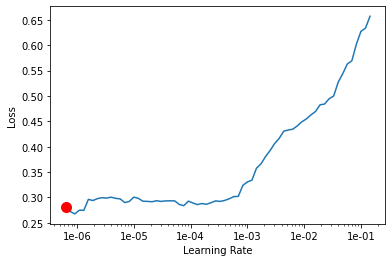

In [0]:
learner.recorder.plot(suggestion=True)

In [0]:
lr = 1e-6
learner.fit_one_cycle(5, lr)

epoch,train_loss,valid_loss,accuracy,time
0,0.267535,0.313137,0.885086,00:17
1,0.276522,0.309499,0.887531,00:17
2,0.271012,0.310675,0.885086,00:18
3,0.284355,0.308652,0.887531,00:17
4,0.289017,0.306585,0.889976,00:17


In [0]:
learner.save("stage-3")

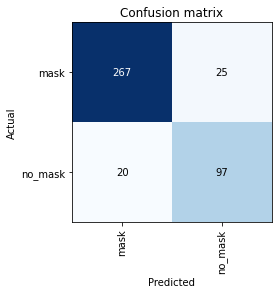

In [0]:
interp = ClassificationInterpretation.from_learner(learner)
interp.plot_confusion_matrix()

In [0]:
from fastai.widgets import ClassConfusion

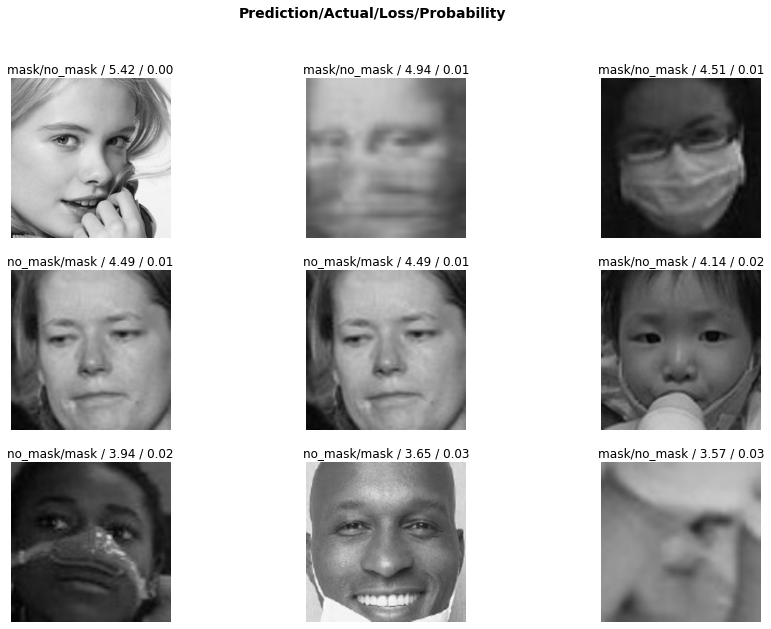

In [0]:
interp.plot_top_losses(9, figsize=(15,10))

In [0]:
interp.most_confused()

[('mask', 'no_mask', 25), ('no_mask', 'mask', 20)]

In [0]:
learner.export()